# Power law distribution with uncertainties

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, powerlaw
from scipy.integrate import quad
import emcee
import time
import corner

%matplotlib inline

### The effect of uncertainties on a power law distribution

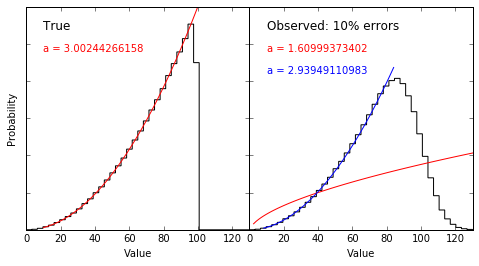

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

N_samples = 1000000

var_true = powerlaw.rvs(3, loc=0, scale=100, size=N_samples)
var_err = norm.rvs(scale=0.10, size=N_samples)
var_observed = var_true + var_err*var_true

# Plot histograms
ax[0].hist(var_true, range=[0,130], histtype='step', color='k', bins=40, label="True", normed=True)
ax[1].hist(var_observed, range=[0,130], histtype='step', color='k', bins=40, label="Observed", normed=True)

# Plot best fit powerlaw
a_true, loc_true, scale_true = powerlaw.fit(var_true)
a_obs, loc_obs, scale_obs = powerlaw.fit(var_observed)

model_x = np.linspace(powerlaw.ppf(0.001, a_true, loc=loc_true, scale=scale_true), 
                      powerlaw.ppf(0.999, a_true, loc=loc_true, scale=scale_true), 100)
ax[0].plot(model_x, powerlaw.pdf(model_x, a_true, loc=loc_true, scale=scale_true), color='r')

model_x = np.linspace(powerlaw.ppf(0.001, a_obs, loc=loc_obs, scale=scale_obs), 
                      powerlaw.ppf(0.999, a_obs, loc=loc_obs, scale=scale_obs), 100)
ax[1].plot(model_x, powerlaw.pdf(model_x, a_obs, loc=loc_obs, scale=scale_obs), color='r')

# What if we only select those values less than the peak maximum?
bins = np.histogram(var_observed, bins=40)
max_bin = bins[1][np.argmax(bins[0])]
var_obs_truncated = var_observed[np.where(var_observed<max_bin)]
n_sys_tr = len(var_obs_truncated) / float(N_samples)
a_obs_tr, loc_obs_tr, scale_obs_tr = powerlaw.fit(var_obs_truncated)
model_x = np.linspace(powerlaw.ppf(0.001, a_obs_tr, loc=loc_obs_tr, scale=scale_obs_tr), 
                      powerlaw.ppf(0.999, a_obs_tr, loc=loc_obs_tr, scale=scale_obs_tr), 100)
ax[1].plot(model_x, n_sys_tr*powerlaw.pdf(model_x, a_obs_tr, loc=loc_obs_tr, scale=scale_obs_tr), color='b')



ax[0].set_xlim(0, 130)
ax[1].set_xlim(0, 130)
#ax[0].set_ylim(0, 1e5)

plt.subplots_adjust(wspace=0)

ax[0].text(10, 0.9*ax[0].get_ylim()[1], "True", fontsize=12)
ax[1].text(10, 0.9*ax[1].get_ylim()[1], "Observed: 10% errors", fontsize=12)

ax[0].text(10, 0.8*ax[0].get_ylim()[1], "a = "+str(a_true), color='r')
ax[1].text(10, 0.8*ax[0].get_ylim()[1], "a = "+str(a_obs), color='r')
ax[1].text(10, 0.7*ax[0].get_ylim()[1], "a = "+str(a_obs_tr), color='b')


ax[0].set_xlabel('Value')
ax[1].set_xlabel('Value')
ax[0].set_ylabel('Probability')

ax[0].set_yticklabels([])

plt.savefig('../figures/power_law_error_test.pdf')
#plt.show()

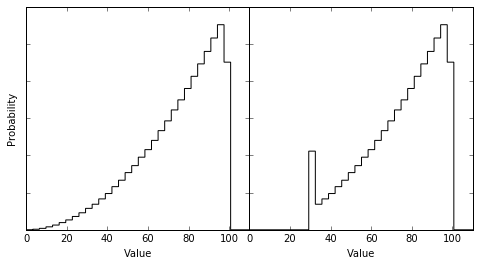

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

N_samples = 1000000

var_true = powerlaw.rvs(3, loc=0, scale=100, size=N_samples)

var = 30.0 * np.ones((N_samples,2))
var[:,0] = var_true

var_obs = np.max(var, axis=1)



# Plot histograms
ax[0].hist(var_true, range=[0,130], histtype='step', color='k', bins=40, label="True", normed=True)
ax[1].hist(var_obs, range=[0,130], histtype='step', color='k', bins=40, label="Observed", normed=True)

ax[0].set_xlim(0, 110)
ax[1].set_xlim(0, 110)


ax[0].set_xlabel('Value')
ax[1].set_xlabel('Value')
ax[0].set_ylabel('Probability')

ax[0].set_yticklabels([])

plt.subplots_adjust(wspace=0)

plt.savefig('../figures/power_law_resolution_test.pdf')
#plt.show()

### Now, let's construct our likelihood function

This is based on the Equation 8 from Koen & Kondlo (2009):
$\mathcal{L} = -\frac{N}{2} \log 2\pi - N \log \sigma
    + N \log \gamma - N \log (L^{-\gamma} - U^{-\gamma}) 
    + \sum_{j=1}^N \log \int_L^U x^{-(\gamma+1)} 
    \exp \left[ -\frac{1}{2} \left( \frac{y_j - x}{\sigma} \right)^2 \right] {\rm d}x$

In [4]:
def ln_posterior(x, data):

    sigma, gamma, L, U = x

    if L<0.0 or L > 6.0:
        return -np.inf
    if U<L or U > 20.0:
        return -np.inf
    if sigma<0.0 or sigma>3.0:
        return -np.inf
    if gamma<0.01 or gamma>10.0:
        return -np.inf
    
    return ln_likelihood(x, data)
    

def ln_likelihood(x, data):

    sigma, gamma, L, U = x
    
    N = len(data)
    
    def get_integrand(x, y, gamma, sigma):
        return np.power(x, -(gamma+1.0)) * np.exp(-0.5*((y-x)/sigma)**2)
    
    
    
    integral = np.zeros(N)
    for i in np.arange(len(data)):
        args = data[i], gamma, sigma
        sol = quad(get_integrand, L, U, args=args)
        integral[i] = sol[0]
    
    ln_likelihood = - N/2.0 * np.log(2.0*np.pi) \
                    - N * np.log(sigma) \
                    + N * np.log(gamma) \
                    - N * np.log(np.power(L, -gamma) - np.power(U, -gamma)) \
                    + np.sum(np.log(integral))
    
    # print sigma, gamma, L, U, integral
    # return integral
    return ln_likelihood

### Obtain our random sample

We make random draws of x from the following power law distribution:
$$\sigma = 0.2$$
$$\gamma = 1.7$$
$$L = 4.0$$
$$U = 10.0$$

We use inverse-transform sampling based on the CDF:
$$F(x) = \frac{L^{-\gamma} - x^{-\gamma}}{L^{-\gamma} - U^{-\gamma}}.$$
$y$ is randomly drawn from the uniform distribution:
$$y \sim U[0,1].$$
Then, we set $F(x)$ to $y$, and solve for $x$:
$$x = \left[ L^{-\gamma} - y(L^{-\gamma} - U^{-\gamma}) \right]^{-1/\gamma}$$


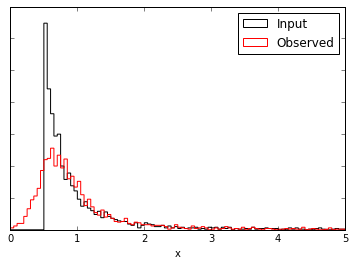

In [90]:
sigma, gamma, L, U = 0.2, 1.7, 0.5, 5.0
p_truths = sigma, gamma, L, U

N = 2000

y = np.random.uniform(size=N)
tmp_x = np.power(L,-gamma) - y * (np.power(L,-gamma)-np.power(U,-gamma))
x_true = np.power(tmp_x, -1.0/gamma)

# No negative values
x_obs = np.abs(x_true + norm.rvs(scale=sigma, size=N))
# # Set minimum value to 0.1
# tmp = 0.01 * np.ones((N,2))
# tmp[:,1] = x + norm.rvs(scale=sigma, size=N)
# x_obs = np.max(tmp, axis=1)

plt.hist(x_true, histtype='step', color='k', range=[0.0, 5.0], bins=100, label='Input')
plt.hist(x_obs, histtype='step', color='r', range=[0.0, 5.0], bins=100, label='Observed')

plt.tick_params(labelleft='off')
plt.xlabel("x")

plt.legend()
plt.show()

### Now, let's construct our emcee functions

In [91]:
def run_emcee(ndim=4, nwalkers=32, nburn=100, nrun=100):

    p0 = np.ones((nwalkers, ndim))
    p0[:,0] = norm.rvs(loc=2.0, scale=0.1, size=nwalkers) # sigma
    p0[:,1] = norm.rvs(loc=3.0, scale=0.1, size=nwalkers) # gamma
    p0[:,2] = norm.rvs(loc=1.0, scale=0.1, size=nwalkers) # L
    p0[:,3] = norm.rvs(loc=10.0, scale=0.1, size=nwalkers) # U

    # Define sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x_obs])

    # Run burn-in
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    # Full run
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, N=nrun)

    return sampler


In [ ]:
start = time.time()

sampler = run_emcee(nburn=2, nrun=2)

print "Elapsed time:", time.time() - start, "seconds"

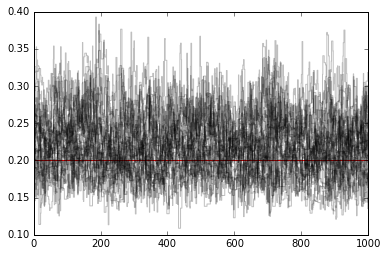

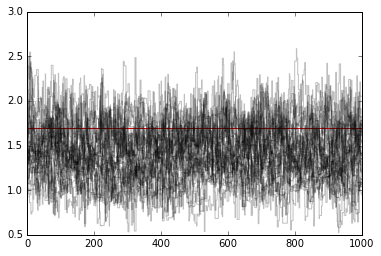

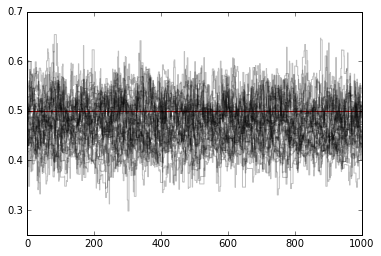

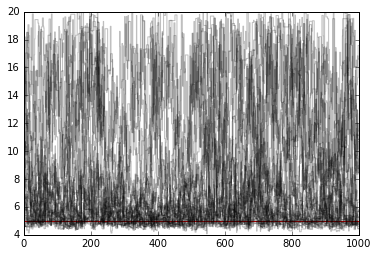

In [82]:
for i in range(sampler.dim):
    plt.figure()
    plt.axhline(p_truths[i], color='r')
    for chain in sampler.chain[...,i]:
        plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')

plt.show()

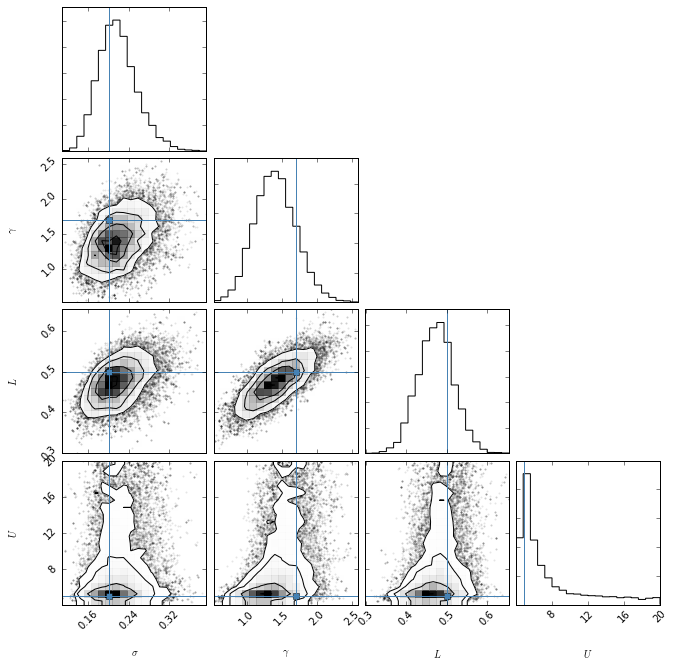

In [88]:
labels = ["$\sigma$","$\gamma$","$L$","$U$"]
corner.corner(sampler.flatchain, labels=labels, truths=p_truths)

#plt.savefig('../figures/power_law_error_MCMC_mock_corner.pdf')
plt.show()

In [58]:
def get_integrand(x, y, gamma, sigma):
    return np.power(x, -(gamma+1.0)) * np.exp(-0.5*((y-x)/sigma)**2)

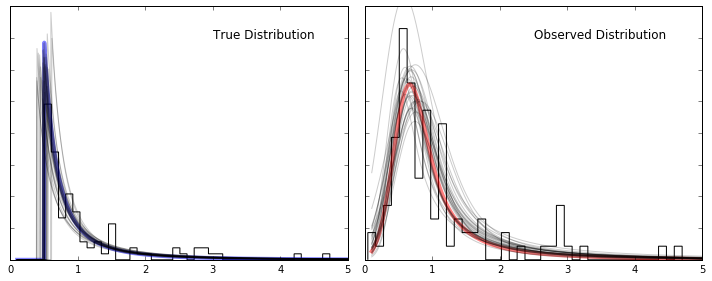

In [87]:
fig, ax = plt.subplots(1,2, figsize=(10,4))


ax[0].hist(x_true, histtype='step', color='k', bins=40, normed=True)
ax[1].hist(x_obs, histtype='step', color='k', bins=40, normed=True)


N = len(sampler.flatchain)

# Plot input distribution - Truths
x = np.linspace(0.1, 5.0, 1000)
sigma, gamma, L, U = p_truths
y = gamma * x**(-(gamma+1)) / (L**(-gamma) - U**(-gamma))
y[x<L] = 0.0
ax[0].plot(x, y, color='b', linewidth=4.0, alpha=0.5)

# Plot input distribution - Observations
integral = np.zeros(1000)
coeff = 1.0/np.sqrt(2.0*np.pi)/sigma * gamma / (L**(-gamma) - U**(-gamma))
for i in np.arange(1000):
    args = x[i], gamma, sigma
    sol = quad(get_integrand, L, U, args=args)
    integral[i] = sol[0]
ax[1].plot(x, integral, color='r', linewidth=4.0, alpha=0.5)


# Plot samples from the posterior
for i in np.random.randint(0, high=N, size=30):
    sigma, gamma, L, U = sampler.flatchain[i]

    # Plot true distribution
    y = gamma * x**(-(gamma+1)) / (L**(-gamma) - U**(-gamma))
    y[x<L] = 0.0
    ax[0].plot(x, y, alpha=0.2, color='k')

    # Plot observed distribution
    integral = np.zeros(1000)
    coeff = 1.0/np.sqrt(2.0*np.pi)/sigma * gamma / (L**(-gamma) - U**(-gamma))
    for i in np.arange(1000):
        args = x[i], gamma, sigma
        sol = quad(get_integrand, L, U, args=args)
        integral[i] = sol[0]
    ax[1].plot(x, integral, color='k', alpha=0.2)
    
    
    
ax[0].set_ylim(0, 4)
ax[1].set_ylim(0, 1.6)

ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

ax[0].text(3.0, 3.5, "True Distribution", fontsize=12)
ax[1].text(2.5, 1.4, "Observed Distribution", fontsize=12)
    

plt.tight_layout()
#plt.savefig('../figures/power_law_error_MCMC_mock.pdf')
plt.show()